# Capter3 K近邻算法
## KNN模型
### 构造存储模型的KDTree

In [6]:
import numpy as np
from graphviz import Digraph
class KDTree():
    def __init__(self):
        self.node_id = 1

    def build_tree(self, x, parent = None, idx = 0):
        if idx >= x.shape[1] - 1:
            idx = 0
        if x.shape[0] == 1:
            root = {}
            root['data'] = x[0][:-1]
            root['label'] = x[0][-1]
            root['parent'] = parent
            root['id'] = self.node_id
            self.node_id = self.node_id + 1
            return root
        if x.shape[0] == 0:
            return None
        mid = np.sort(x[:, idx])[x.shape[0]//2]
        mid_tensor = x[x[:, idx]==mid][0]
        root = {}
        root['data'] = mid_tensor[:-1]
        root['label'] = mid_tensor[-1]
        root['parent'] = parent
        root['id'] = self.node_id
        self.node_id = self.node_id + 1
        root['left'] = self.build_tree(x[x[:, idx]<mid], root, idx + 1)
        root['right'] = self.build_tree(x[x[:, idx]>mid], root, idx + 1)
        return root

    def format_dot(self, dot, node):
        if not node:
            return
        node_label = "{}_{}_{}".format(node['id'], node['data'], node['label'])
        dot.node(str(node['id']), label=node_label)
        if node['parent']:
            dot.edge(str(node['parent']['id']), str(node['id']))
        if 'left' in node:
            self.format_dot(dot, node['left'])
        if 'right' in node:
            self.format_dot(dot, node['right'])

    def print_tree(self, root):
        dot = Digraph(comment='KD-Tree')
        self.format_dot(dot, root)
        return dot


### KNN模型

In [7]:
import pandas as pd
class KNN():
    def __init__(self, k):
        self.k = k
        self.tree = KDTree()

    def fit(self, x, y):
        data = np.column_stack((x, y))
        self.root = self.tree.build_tree(data)
        self.dot = self.tree.print_tree(self.root)
    
    def predict(self, test_data):
        pre_lst = []
        for i in range(test_data.shape[0]):
            self.neibor_num = 0
            self.heap = []
            self.search(test_data[i])
            df = pd.DataFrame(np.array(self.heap), columns = ['dist', 'label', 'id'])
            pre_lst.append(df.groupby('label', as_index=False).count().max()['label'])       
        return np.array(pre_lst)

    def set_minK(self, dist, node):
        if len(self.heap) < self.k:
            self.heap.append([dist, node['label'], node['id']])
            dist_idx = len(self.heap) - 1
            if dist_idx == 0:
                return
            p_idx = (dist_idx - 1) // 2
            while self.heap[dist_idx][0] > self.heap[p_idx][0]:
                self.heap[dist_idx], self.heap[p_idx] = self.heap[p_idx], self.heap[dist_idx]
                dist_idx = p_idx
                p_idx = (dist_idx - 1) // 2
                if dist_idx == 0:
                    return
        else:
            if dist >= self.heap[0][0]:
                return
            self.heap[0] = [dist, node['label'], node['id']]
            dist_idx = 0
            c_idx = dist_idx*2+1
            if c_idx > self.k - 1:
                return
            if c_idx+1 < self.k and self.heap[c_idx+1][0] > self.heap[c_idx][0]:
                c_idx = c_idx+1
            while self.heap[dist_idx][0] < self.heap[c_idx][0]:
                self.heap[dist_idx], self.heap[c_idx] = self.heap[c_idx], self.heap[dist_idx]
                dist_idx = c_idx
                c_idx = dist_idx*2+1
                if c_idx > self.k - 1:
                    return
                if c_idx+1 < self.k and self.heap[c_idx+1][0] > self.heap[c_idx][0]:
                    c_idx = c_idx+1           
        return

    def cal_dist(self, x, y):
        return np.square(np.subtract(x, y)).sum()

    def set_neibor(self, x, node):
        dist = self.cal_dist(x, node['data'])
        self.set_minK(dist, node)
        node['visit'] = True
        self.neibor_num = self.neibor_num + 1

    def search_sub_tree(self, node, x, idx):
        self.set_neibor(x, node)
        fea_num = x.shape[0]
        if self.neibor_num < self.k or self.cal_dist(np.array(x[idx%fea_num]), np.array(node['data'][idx%fea_num])) < self.heap[0][0]:
            if 'left' in node and node['left']:
                self.search_sub_tree(node['left'], x, idx+1)
            if 'right' in node and node['right']:
                self.search_sub_tree(node['right'], x, idx+1)
            
    def search(self, x):
        idx = -1
        node = self.root
        fea_num = x.shape[0]
        break_flag = False
        while node:
            idx = idx+1
            if x[idx%fea_num] <= node['data'][idx%fea_num]:
                if 'left' in node and node['left']:
                    node = node['left']
                else:
                    break_flag = True
            else:
                if 'right' in node and node['right']:
                    node = node['right']
                else: 
                    break_flag = True
            if break_flag:
                if 'left' in node and node['left']:
                    node = node['left']
                    idx = idx + 1
                if 'right' in node and node['right']:
                    node = node['right']
                    idx = idx + 1
                break
        self.set_neibor(x, node)
        while idx > 0:
            node = node['parent']
            idx = idx - 1
            self.set_neibor(x, node)
            if self.neibor_num < self.k or self.cal_dist(np.array(x[idx%fea_num]), np.array(node['data'][idx%fea_num])) < self.heap[0][0]:
                if 'right' in node and node['right']:
                    if 'visit' not in node['right']:
                        self.search_sub_tree(node['right'], x, idx)
                elif 'left' in node and node['right']:
                    if 'visit' not in node['left']:
                        self.search_sub_tree(node['left'], x, idx)

    def get_accuracy(self, gt_y, pre_y):
        diff = np.subtract(gt_y, pre_y)
        err = diff[diff!=0].shape[0]
        return 1 - err/gt_y.shape[0]

    def plot_decision_boundary(self, fea, label, ax, title=''):
        fea1_min, fea1_max = fea[:, 0].min() - 0.5, fea[:, 0].max() + 0.5
        fea2_min, fea2_max = fea[:, 1].min() - 0.5, fea[:, 1].max() + 0.5
        s = 0.05
        g_fea1, g_fea2 = np.meshgrid(np.arange(fea1_min, fea1_max, s), np.arange(fea2_min, fea2_max, s))
        pre_y = self.predict(np.c_[g_fea1.ravel(), g_fea2.ravel()])
        pre_y = pre_y.reshape(g_fea1.shape)
        ax.contourf(g_fea1, g_fea2, pre_y, cmap=plt.cm.Spectral)
        ax.scatter(fea[:, 0], fea[:, 1], c = label, s = 20)
        if len(title) > 0:
            ax.set_title(title)

    def print_tree(self):
        return self.dot


## 模型测试

In [8]:
%matplotlib widget
from sklearn import datasets
import matplotlib.pyplot as plt

sample_num = 200
train_num = 100
inputs, labels = datasets.make_classification(n_samples=sample_num, n_features=2, n_classes=2, n_redundant=0)
train_x = inputs[:train_num]
train_y = labels[:train_num]
test_x = inputs[sample_num - train_num:]
test_y = labels[sample_num - train_num:]

model = KNN(2)
model.fit(train_x, train_y)
pre_y = model.predict(test_x)
print("accuracy: %.2f" % model.get_accuracy(test_y, pre_y))
model.plot_decision_boundary(test_x, test_y, plt)


accuracy: 0.84


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

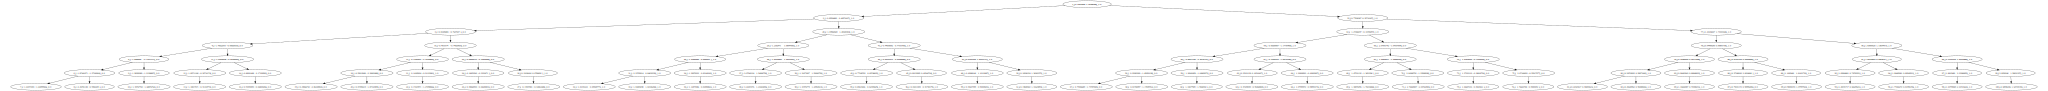

In [9]:
model.print_tree()